# 1. Lib

In [14]:
import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Fetching

In [15]:
def resolve_data_dir(
    dataset_name="pediatric_skin_data",
    data_folder_name="data"
):
    cwd = Path.cwd().resolve()

    for parent in [cwd] + list(cwd.parents):
        candidate = parent / data_folder_name / dataset_name
        if candidate.exists():
            return candidate

    raise FileNotFoundError(
        f"Cannot locate dataset '{dataset_name}' "
        f"inside a '{data_folder_name}' directory."
    )


DATA_DIR = resolve_data_dir()

print(f"Resolved dataset path:\n{DATA_DIR}")

VALID_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp"}
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Resolved dataset path:
C:\Users\lammi\Downloads\medscreening\agents\image_agent\data\pediatric_skin_data


In [16]:
class_dirs = sorted(
    d for d in DATA_DIR.iterdir() if d.is_dir()
)

assert len(class_dirs) > 0, "No class folders found."

print(f"\nTotal classes: {len(class_dirs)}")
for d in class_dirs:
    print(f"  {d.name}")


Total classes: 8
  0_Eczema_Dermatitis
  1_Bacterial_Infections
  2_Fungal_Infections
  3_Viral_Infections
  4_Infestations
  5_Acneiform
  6_Vascular_Benign
  7_Healthy_Skin


In [17]:
records = []
corrupted_files = []

for class_dir in class_dirs:
    class_name = class_dir.name

    for img_path in class_dir.iterdir():
        if img_path.suffix.lower() not in VALID_EXTENSIONS:
            continue

        try:
            with Image.open(img_path) as img:
                width, height = img.size
                mode = img.mode

            records.append(
                {
                    "class": class_name,
                    "path": img_path.as_posix(),
                    "width": width,
                    "height": height,
                    "aspect_ratio": width / height,
                    "pixels": width * height,
                    "file_size_kb": img_path.stat().st_size / 1024,
                    "mode": mode,
                }
            )

        except Exception:
            corrupted_files.append(img_path.as_posix())

df = pd.DataFrame(records)

print(f"\nTotal images scanned: {len(df)}")
print(f"Corrupted images: {len(corrupted_files)}")


Total images scanned: 166161
Corrupted images: 0


# 3. EDA 

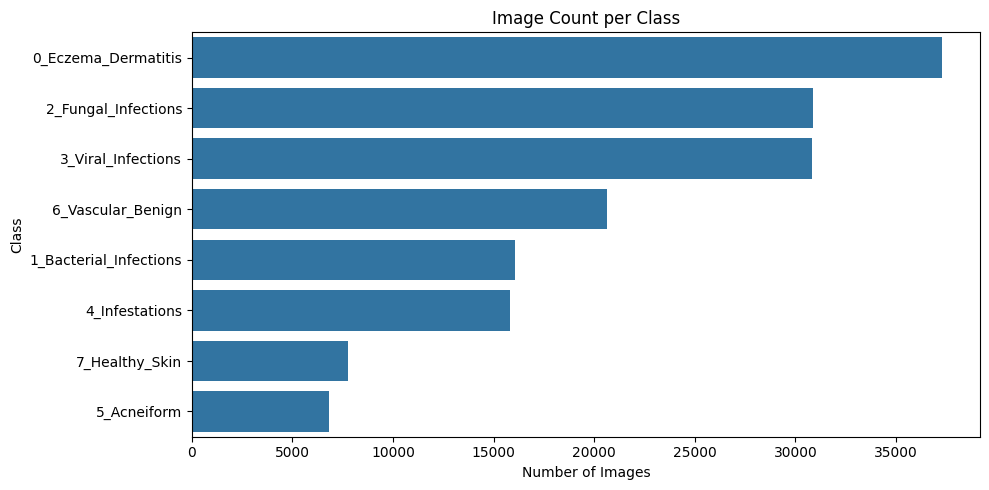

Imbalance ratio (max/min): 5.46


In [18]:
class_counts = (
    df["class"]
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=class_counts.values,
    y=class_counts.index
)
plt.title("Image Count per Class")
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

In [25]:
class_counts

class
0_Eczema_Dermatitis       37310
2_Fungal_Infections       30900
3_Viral_Infections        30816
6_Vascular_Benign         20658
1_Bacterial_Infections    16042
4_Infestations            15840
7_Healthy_Skin             7758
5_Acneiform                6837
Name: count, dtype: int64

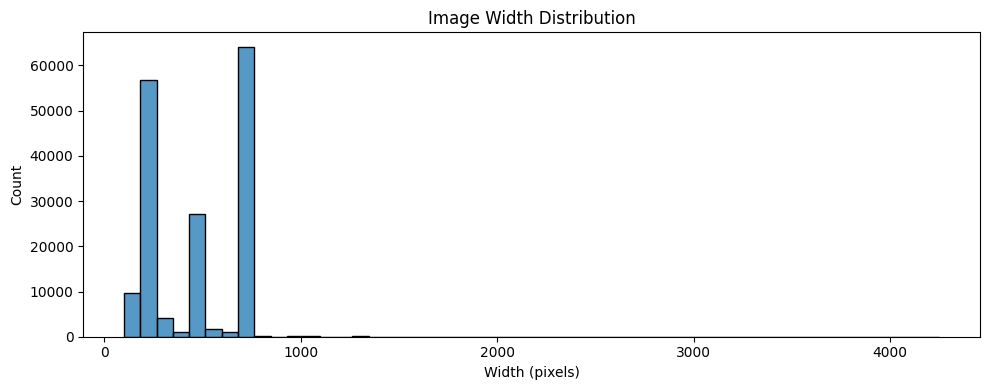

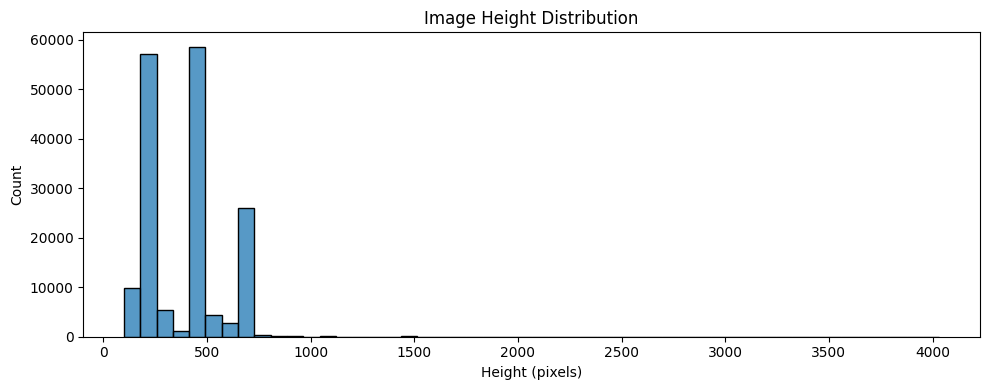

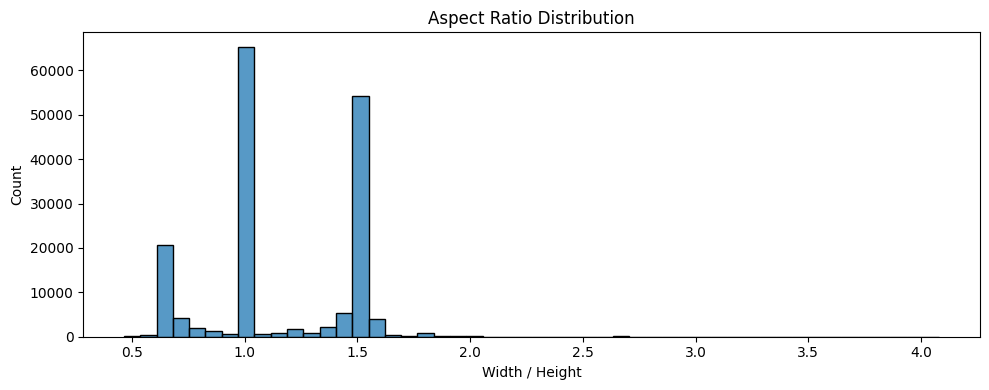

In [19]:
plt.figure(figsize=(10, 4))
sns.histplot(df["width"], bins=50)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df["height"], bins=50)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df["aspect_ratio"], bins=50)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [20]:
size_stats = (
    df.groupby("class")[["width", "height", "pixels"]]
    .agg(["mean", "median", "min", "max"])
)

display(size_stats)

width                        height              \
                              mean median  min   max        mean median  min   
class                                                                          
0_Eczema_Dermatitis     584.010721  720.0  153  4250  503.363495  477.0  111   
1_Bacterial_Infections  437.101733  265.0  179   720  388.125047  265.0  179   
2_Fungal_Infections     292.893042  224.0  128   720  264.991715  224.0  128   
3_Viral_Infections      431.175071  262.0  179   720  378.581192  262.0  179   
4_Infestations          444.021970  266.0  181   720  374.639710  266.0  181   
5_Acneiform             647.006582  720.0  326   720  552.565306  480.0  405   
6_Vascular_Benign       532.603737  720.0  224   720  433.395295  472.0  224   
7_Healthy_Skin          460.011601  500.0  100  1280  479.198505  449.0  100   

                                     pixels                              
                         max           mean    median     min       max  
class                                                                    
0_Eczema_Dermatitis     4032  313423.563334  339840.0   29260  13549000  
1_Bacterial_Infections   720  199610.183144   70225.0   32041    508320  
2_Fungal_Infections      720  104511.887929   50176.0   16384    504000  
3_Viral_Infections      1128  194380.277875   68644.0   32041    812160  
4_Infestations           720  196190.251831   70756.0   32761    509040  
5_Acneiform              768  346034.866462  341280.0  133334    552960  
6_Vascular_Benign        720  254100.767548  339840.0   50176    506160  
7_Healthy_Skin          1792  234386.132508  196000.0   15000   2293760

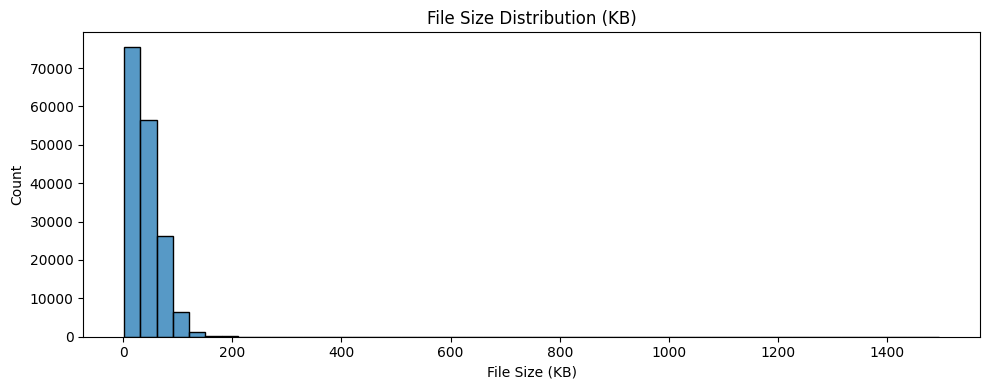

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0_Eczema_Dermatitis,37310.0,49.634812,33.872402,1.541016,35.031738,48.919922,63.421387,1495.268555
1_Bacterial_Infections,16042.0,34.392173,29.055074,3.399414,7.421143,33.543457,57.693604,175.015625
2_Fungal_Infections,30900.0,20.557378,29.132780,1.830078,3.874023,7.196289,11.804688,230.974609
3_Viral_Infections,30816.0,30.820684,28.696953,2.859375,7.008789,11.448730,50.778320,232.761719
4_Infestations,15840.0,30.914031,27.384788,3.009766,6.706055,14.468750,51.864502,188.500977
5_Acneiform,6837.0,61.860037,20.386388,22.504883,48.110352,58.116211,71.068359,451.894531
6_Vascular_Benign,20658.0,49.829717,30.238754,3.014648,34.099121,52.178223,66.239990,213.538086
7_Healthy_Skin,7758.0,27.248017,16.637900,2.175781,16.959717,23.696289,34.186523,483.810547


In [21]:
plt.figure(figsize=(10, 4))
sns.histplot(df["file_size_kb"], bins=50)
plt.title("File Size Distribution (KB)")
plt.xlabel("File Size (KB)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

file_size_stats = (
    df.groupby("class")["file_size_kb"]
    .describe()
)

display(file_size_stats)

In [22]:
mode_counts = df["mode"].value_counts()
print("\nImage mode distribution:")
print(mode_counts)


Image mode distribution:
mode
RGB     166158
RGBA         1
L            1
P            1
Name: count, dtype: int64


In [23]:
summary = pd.Series(
    {
        "total_images": len(df),
        "total_classes": df["class"].nunique(),
        "min_images_per_class": class_counts.min(),
        "max_images_per_class": class_counts.max(),
        "mean_width": df["width"].mean(),
        "mean_height": df["height"].mean(),
        "mean_file_size_kb": df["file_size_kb"].mean(),
        "corrupted_images": len(corrupted_files),
    },
    name="Dataset Summary",
)

display(summary)

total_images            166161.000000
total_classes                8.000000
min_images_per_class      6837.000000
max_images_per_class     37310.000000
mean_width                 464.411637
mean_height                404.693520
mean_file_size_kb           36.963999
corrupted_images             0.000000
Name: Dataset Summary, dtype: float64

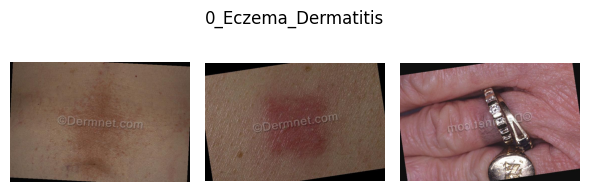

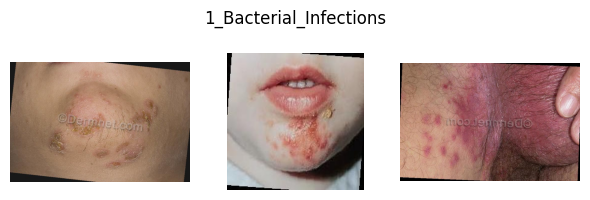

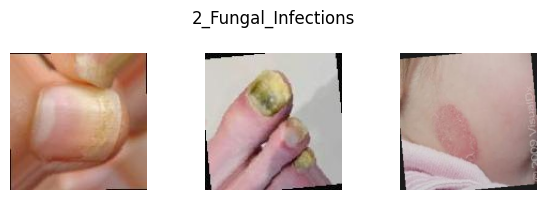

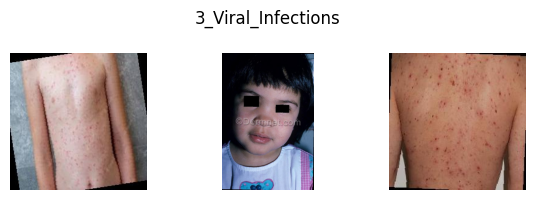

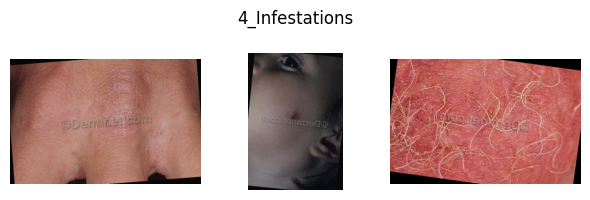

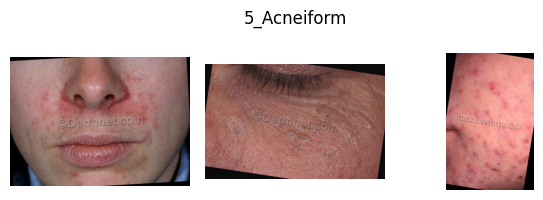

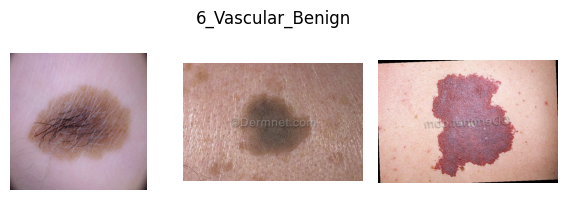

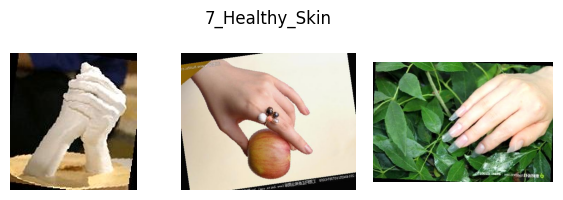

In [24]:
def show_random_samples(dataframe, samples_per_class=3):
    for class_name in sorted(dataframe["class"].unique()):
        subset = dataframe[dataframe["class"] == class_name]
        sample = subset.sample(
            n=min(samples_per_class, len(subset)),
            random_state=RANDOM_SEED
        )

        plt.figure(figsize=(samples_per_class * 2, 2))
        for i, row in enumerate(sample.itertuples()):
            img = Image.open(row.path)
            plt.subplot(1, samples_per_class, i + 1)
            plt.imshow(img)
            plt.axis("off")

        plt.suptitle(class_name)
        plt.tight_layout()
        plt.show()


show_random_samples(df)